In [7]:
pip install torch===1.6.0 torchvision===0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
Note: you may need to restart the kernel to use updated packages.


In [4]:
conda install pytorch==1.5.1 torchvision==0.6.1 cudatoolkit=10.2 -c pytorch

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'pytorch'


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from bs4 import BeautifulSoup
import torchvision
from torchvision import transforms, datasets, models
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import matplotlib.patches as patches

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [18]:

def generate_box(obj):
    
    xmin = int(obj.find('xmin').text)
    ymin = int(obj.find('ymin').text)
    xmax = int(obj.find('xmax').text)
    ymax = int(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

def generate_label(obj):
    if obj.find('name').text == "with_mask":
        return 1
    elif obj.find('name').text == "mask_weared_incorrect":
        return 2
    return 0


def generate_label(obj): 
    if obj.find('name').text == "with_mask": 
        return 2 
    elif obj.find('name').text == "mask_weared_incorrect": 
        return 3 
    return 1

def generate_target(image_id, file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml')
        objects = soup.find_all('object')

        num_objs = len(objects)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Labels (In my case, I only one class: target class or background)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        # Tensorise img_id
        img_id = torch.tensor([image_id])
        # Annotation is in dictionary format
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = img_id
        
        return target


In [5]:
imgs = list(sorted(os.listdir("D:/Add/mask/mask/images")))

In [3]:
labels = list(sorted(os.listdir("D:/Add/mask/mask/annotations")))

In [9]:
class MaskDataset(object):
    def __init__(self, transforms):
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir("D:/Add/mask/mask/images")))
#         self.labels = list(sorted(os.listdir("/kaggle/input/face-mask-detection/annotations/")))

    def __getitem__(self, idx):
        # load images ad masks
        file_image = 'maksssksksss'+ str(idx) + '.png'
        file_label = 'maksssksksss'+ str(idx) + '.xml'
        img_path = os.path.join("D:/Add/mask/mask/images/", file_image)
        label_path = os.path.join("D:/Add/mask/mask/annotations/", file_label)
        img = Image.open(img_path).convert("RGB")
        #Generate Label
        target = generate_target(idx, label_path)
        
        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [10]:
data_transform = transforms.Compose([
        transforms.ToTensor(), 
    ])

In [11]:
def collate_fn(batch):
    return tuple(zip(*batch))

dataset = MaskDataset(data_transform)
data_loader = torch.utils.data.DataLoader(
 dataset, batch_size=1, collate_fn=collate_fn)

In [12]:
torch.cuda.is_available()

True

In [13]:
torch.backends.cudnn.enabled

True

In [20]:
torch.cuda.empty_cache()

# Model

In [15]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes+1)

    return model

In [16]:
model = get_model_instance_segmentation(3)

In [21]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
for imgs, annotations in data_loader:
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    print(annotations)
    break

[{'boxes': tensor([[ 79., 105., 109., 142.],
        [185., 100., 226., 144.],
        [325.,  90., 360., 141.]], device='cuda:0'), 'labels': tensor([1, 2, 1], device='cuda:0'), 'image_id': tensor([0], device='cuda:0')}]


# Train Model

In [22]:
num_epochs = 10
model.to(device)
    
# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

len_dataloader = len(data_loader)

for epoch in range(num_epochs):
    model.train()
    i = 0    
    epoch_loss = 0
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model([imgs[0]], [annotations[0]])
        losses = sum(loss for loss in loss_dict.values())        

        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 
#         print(f'Iteration: {i}/{len_dataloader}, Loss: {losses}')
        epoch_loss += losses
    print(epoch_loss)


C:\Users\ngtze\Anaconda3\lib\site-packages\torchvision\ops\boxes.py:101: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:766.)
  keep = keep.nonzero().squeeze(1)


tensor(348.9329, device='cuda:0', grad_fn=<AddBackward0>)
tensor(250.4241, device='cuda:0', grad_fn=<AddBackward0>)
tensor(209.9233, device='cuda:0', grad_fn=<AddBackward0>)
tensor(187.0351, device='cuda:0', grad_fn=<AddBackward0>)
tensor(163.4259, device='cuda:0', grad_fn=<AddBackward0>)
tensor(153.3485, device='cuda:0', grad_fn=<AddBackward0>)
tensor(136.6026, device='cuda:0', grad_fn=<AddBackward0>)
tensor(124.7035, device='cuda:0', grad_fn=<AddBackward0>)
tensor(123.7265, device='cuda:0', grad_fn=<AddBackward0>)
tensor(114.8116, device='cuda:0', grad_fn=<AddBackward0>)


In [23]:
for imgs, annotations in data_loader:
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        break

In [25]:
model.eval()
preds = model([imgs[0]])
preds

[{'boxes': tensor([[185.2316,  99.9574, 227.6073, 145.4748],
          [ 79.6530, 104.8060, 110.0101, 142.6148],
          [325.2034,  90.0777, 361.6808, 142.0979],
          [443.6924, 184.8891, 460.5094, 207.5329]], device='cuda:0',
         grad_fn=<StackBackward>),
  'labels': tensor([2, 1, 1, 2], device='cuda:0'),
  'scores': tensor([0.9977, 0.9944, 0.9939, 0.1212], device='cuda:0',
         grad_fn=<IndexBackward>)}]

# Function to plot image

In [56]:
def plot_image(img_tensor, annotation, block=True):

    fig,ax = plt.subplots(1)
    img = img_tensor.cpu().data
    # Display the image
    ax.imshow( np.array( img.permute(1, 2, 0) ) )

    for box, label in zip( annotation["boxes"], annotation["labels"] ):
        xmin, ymin, xmax, ymax = box
        # Create a Rectangle patch
        if label==2:
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='b',facecolor='none')
        else:
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(rect)
        ax.axis("off")
    plt.show(block=block)

Prediction


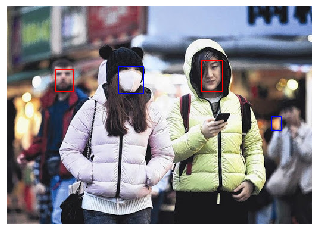

Target


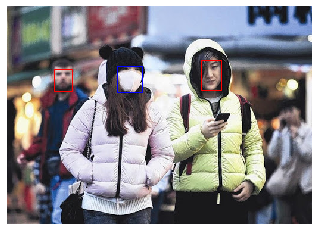

In [57]:
print("Prediction")
plot_image(imgs[0], preds[0])
print("Target")
plot_image(imgs[0], annotations[0])

In [58]:
torch.save(model.state_dict(),'model.pt')

In [59]:
model2 = get_model_instance_segmentation(3)

# Save Model

In [60]:
model2.load_state_dict(torch.load('model.pt'))
model2.eval()
model2.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample)

# Load Model

In [65]:
pred2 = model2([imgs[0]])

Predict with loaded model


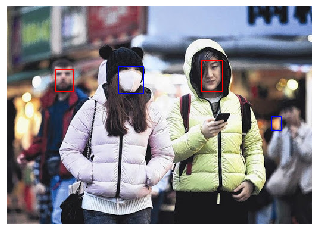

In [66]:
print("Predict with loaded model")
plot_image(imgs[0], pred2[0])